# SLA1 Camera Characterization

## Calibration of 30s Darks

On May 8, 2024 (UTC) we took various dark exposures with the [QHY42 Pro](https://www.qhyccd.com/qhy42pro/) camera.

This notebook combines the darks into a master dark, and then subtracts them from each individual dark
with the goal of characterizing hot pixels and dark current.


In [1]:
# THIS COMMENT IS THE LONGEST A LINE CAN BE AND STILL RENDER COMPLETELY WHEN PRINTING IN LANDSCAPE MODE.

import os, sys
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection, combine, subtract_dark, flat_correct # Combiner
import astroalign as aa
import matplotlib.pyplot as plt
%matplotlib inline
from math import log10, floor

home_directory = os.path.expanduser('~')

# soft link to directory containing raw images
sessions_directory = os.path.join(home_directory, '2024 SLA Sessions')

uv_project_directory = os.path.join(home_directory, 'Projects', 'uv-transients')
analysis_directory = os.path.join(uv_project_directory, 'analyses', '30s_darks')

# The path to the first dark on SLA1 is D:/Raw/2024-05-08/03_38_48/Dark30s/00001.fits
# The files to be processed need to be mirrored on the local machine
# at ~/2024 SLA Sessions/ using the same subdirectory structure.
capture_date = '2024-05-08'
capture_time = '03_38_48'
object_name = 'Dark30s'

# subdirectory for the 30-second darks (following SharpCap Pro capture directory conventions)
dark_directory = os.path.join(
    sessions_directory,
    capture_date,
    capture_time,
    object_name
)

# exposure duration

dark_exposure = 30.0
dark_exposure_with_ccdproc_units = dark_exposure * u.second

# FITS header confirmation

def confirm_fits_header(image, dimensions, exposure_time, filter):
    header = image.header
    assert header['NAXIS1'] == dimensions[0]
    assert header['NAXIS2'] == dimensions[1]
    assert header['EXPTIME'] == exposure_time
    if filter:
        assert header['FILTER'].rstrip() == filter

# Log stretch utility

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        if pixel_value <= 1.0:
            return 0
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn

# After all the preliminaries, we read in and combine the dark files

dark_files = ImageFileCollection(dark_directory).files_filtered(include_path='True')

darks = [CCDData.read(file, unit=u.adu) for file in dark_files]

for dark in darks:
    confirm_fits_header(dark, (2048, 2048), dark_exposure, None)

combination_method = 'median'  # alternatively, the method can be 'average'

master_dark = combine(darks, method=combination_method)


Set MJD-END to 60438.151953 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.151953 from DATE-END'.
Set MJD-END to 60438.152301 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.152301 from DATE-END'.
Set MJD-END to 60438.152648 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.152648 from DATE-END'.
Set MJD-END to 60438.152995 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.152995 from DATE-END'.
Set MJD-END to 60438.153342 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.153342 from DATE-END'.
Set MJD-END to 60438.153689 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.153689 from DATE-END'.
Set MJD-END to 60438.154037 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.154037 from DATE-END'.
Set MJD-END to 60438.154384 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.154384 from DATE-END'.
Set MJD-END to 60438.154731 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60438.154731 from DATE-END'.
Set MJD-END to 60438.155078 from DATE-END'. [a

## Inspect the Data of the Master Dark and a Representative Dark

At this point, the darks and the master_dark are observed to 
have values ranging from something like 18000 to 25000 ADU,
with some outliers far outside that range.


In [2]:
# np.set_printoptions(threshold=sys.maxsize) # Uncommenting this line will cause serious I/O strain

master_dark.data

array([[6.40000e+03, 6.15100e+04, 3.50000e+00, ..., 1.49450e+04,
        1.49765e+04, 1.43900e+04],
       [5.74100e+03, 5.74100e+03, 1.76055e+04, ..., 1.44415e+04,
        1.67170e+04, 1.41960e+04],
       [1.72130e+04, 1.78930e+04, 1.79250e+04, ..., 1.44100e+04,
        1.49765e+04, 1.63280e+04],
       ...,
       [8.01100e+03, 8.90350e+03, 8.34400e+03, ..., 1.55045e+04,
        1.51520e+04, 1.57850e+04],
       [8.82850e+03, 9.12900e+03, 9.48850e+03, ..., 1.85450e+04,
        1.91905e+04, 1.79245e+04],
       [1.04655e+04, 1.83845e+04, 1.13215e+04, ..., 2.78300e+04,
        2.51730e+04, 2.46185e+04]])

In [3]:
darks[5].data

array([[ 6400, 61638,     0, ..., 14966, 14966, 14288],
       [ 5741,  5741, 17478, ..., 15172, 16338, 14002],
       [17457, 18224, 17478, ..., 14268, 16087, 16234],
       ...,
       [ 7993,  9072,  8196, ..., 15131, 15921, 15691],
       [ 8791,  9148,  9507, ..., 18760, 19255, 17520],
       [11029, 18374, 11557, ..., 28432, 24336, 25038]], dtype=uint16)

## Display the Master Dark and a Representative Dark

We will display the range from 5000 to 30000, which of course
cannot be accomplished with 256 gray scale values, so we will
also do logarthmic stretching of that range.

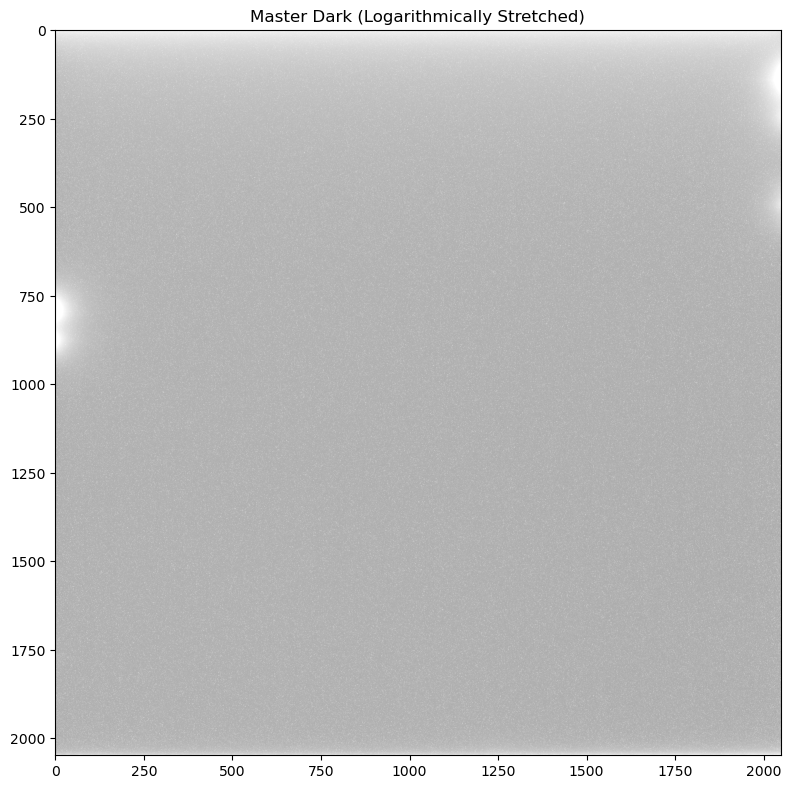

In [4]:
# Log stretch

stretch_function = log_stretch_transform(5000, 25000)
stretch_transform = np.vectorize(stretch_function)

stretched_master_dark = stretch_transform(master_dark.data)

stretched_darks = [
    stretch_transform(dark.data) for dark in darks
]

# Display the master dark

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(stretched_master_dark.data, cmap='gray')
axes.set_title("Master Dark (Logarithmically Stretched)")

plt.tight_layout()
plt.show()


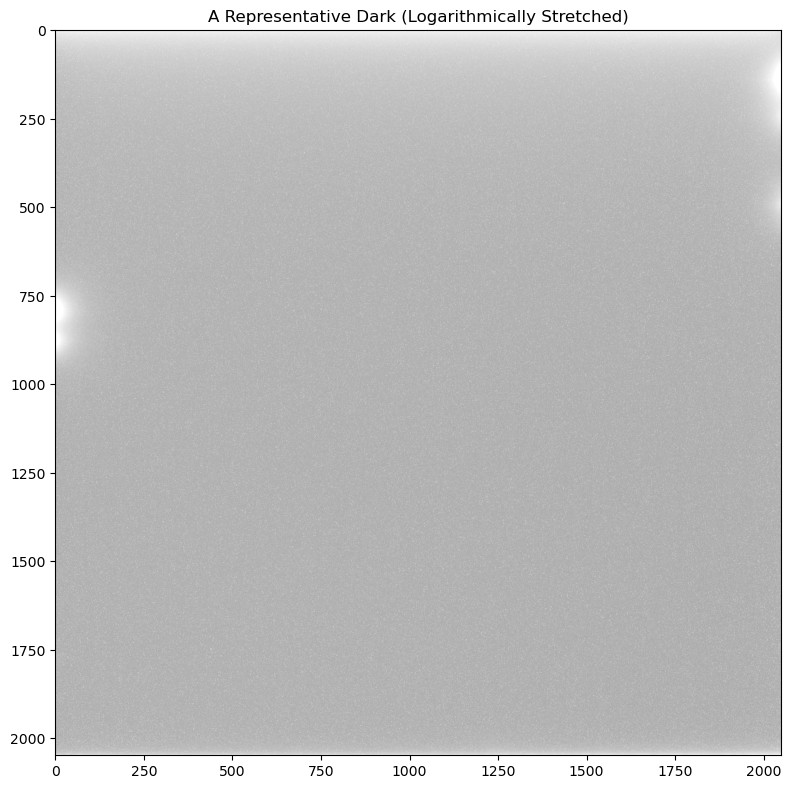

In [5]:
# Display a representative dark

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(stretched_darks[5].data, cmap='gray')
axes.set_title("A Representative Dark (Logarithmically Stretched)")

plt.tight_layout()
plt.show()


## Subtract Master Dark from Darks

In [6]:
subtracted_darks = [
    subtract_dark(
        dark,
        master_dark,
        data_exposure=dark_exposure_with_ccdproc_units,
        dark_exposure=dark_exposure_with_ccdproc_units,
        scale=False
    )
    for dark in darks
]


## Inspect the Data of a Representative Subtracted Dark

The subtracted darks are observed to 
have values ranging from something like -700 to 1300 ADU.

In [7]:
# np.set_printoptions(threshold=sys.maxsize) # Uncommenting this line will cause serious I/O strain

representative_dark = subtracted_darks[5]
representative_dark.data

array([[   0. ,  128. ,   -3.5, ...,   21. ,  -10.5, -102. ],
       [   0. ,    0. , -127.5, ...,  730.5, -379. , -194. ],
       [ 244. ,  331. , -447. , ..., -142. , 1110.5,  -94. ],
       ...,
       [ -18. ,  168.5, -148. , ..., -373.5,  769. ,  -94. ],
       [ -37.5,   19. ,   18.5, ...,  215. ,   64.5, -404.5],
       [ 563.5,  -10.5,  235.5, ...,  602. , -837. ,  419.5]])

## Display a Representative Subtracted Dark

We will display the range from -1000 to +1000, which of course
cannot be accomplished with 256 gray scale values, so we will
also do a linear mapping of that range.

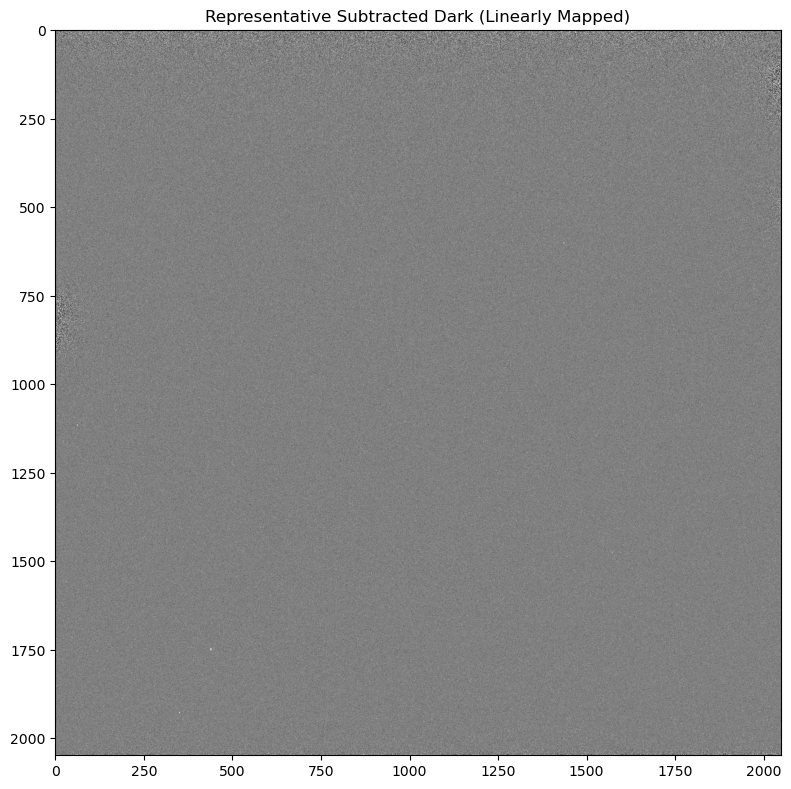

In [8]:
def linear_transform(black_point, saturation_range):
    
    def fn(pixel_value):
        pixel_value -= black_point
        if pixel_value <= 0.0:
            return 0
        else:
            if pixel_value >= saturation_range:
                return 255;
            else:
                return floor(256 * pixel_value / saturation_range)
        
    return fn


stretch_function2 = linear_transform(-1000, 2000)
stretch_transform2 = np.vectorize(stretch_function2)

stretched_representative_dark_data = stretch_transform2(representative_dark.data)

# Display the representative subtracted dark

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(stretched_representative_dark_data, cmap='gray')
axes.set_title("Representative Subtracted Dark (Linearly Mapped)")

plt.tight_layout()
plt.show()


## Display a Subframe of the Representative Subtracted Dark

Home in on the crud in the lower left of the above image.

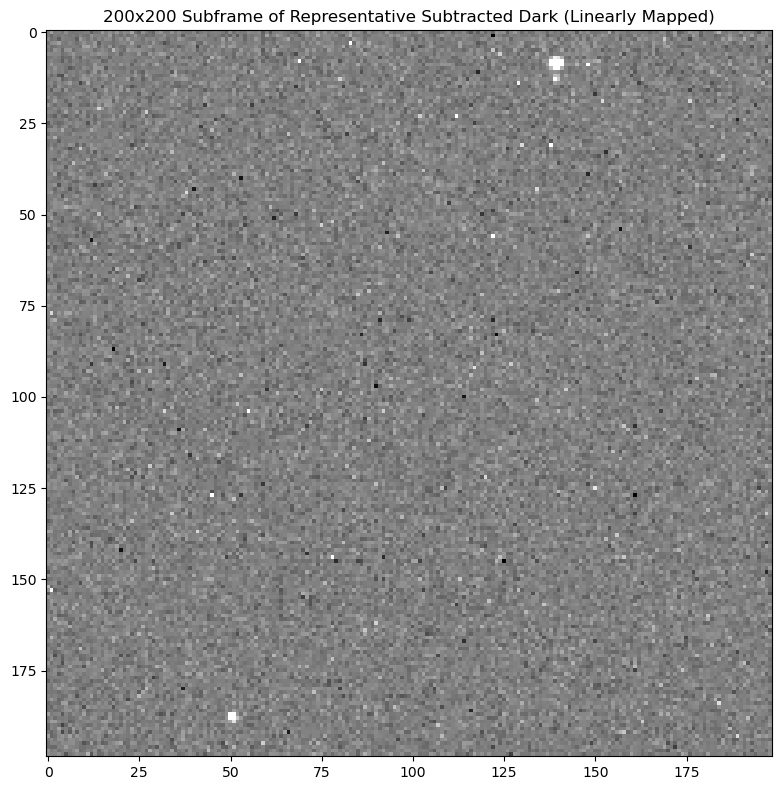

In [9]:
subframe = stretched_representative_dark_data[1740:1939, 300:499]

# Display the representative subtracted dark

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(subframe, cmap='gray')
axes.set_title("200x200 Subframe of Representative Subtracted Dark (Linearly Mapped)")

plt.tight_layout()
plt.show()
